# "Cross-validation" des modèles

In [ ]:
learning_rate = 0.05
num_epochs = 3000
N = 250

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6):
    
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=False)    
        self.logit0 = torch.nn.Linear(1, 1) 

    def forward(self, x):
        p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
        out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
        return out

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                verbose=False):

    logistic_model = LogisticRegressionModel()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    for epoch in range(int(num_epochs)):

        optimizer.zero_grad()
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {loss.item():.5f}")

    logistic_model.eval()
    return logistic_model, loss.item()

kezako?

In [5]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0. Loss: 0.67712.
Iteration: 93. Loss: 0.38132.
Iteration: 186. Loss: 0.35889.
Iteration: 279. Loss: 0.35571.
Iteration: 372. Loss: 0.35519.
Iteration: 465. Loss: 0.35506.
Iteration: 558. Loss: 0.35492.
Iteration: 651. Loss: 0.35470.
Iteration: 744. Loss: 0.35441.
Iteration: 837. Loss: 0.35414.
Iteration: 930. Loss: 0.35393.
Iteration: 1023. Loss: 0.35378.
Iteration: 1116. Loss: 0.35368.
Iteration: 1209. Loss: 0.35362.
Iteration: 1302. Loss: 0.35358.
Iteration: 1395. Loss: 0.35356.
Iteration: 1488. Loss: 0.35355.
Iteration: 1581. Loss: 0.35354.
Iteration: 1674. Loss: 0.35354.
Iteration: 1767. Loss: 0.35353.
Iteration: 1860. Loss: 0.35353.
Iteration: 1953. Loss: 0.35353.
Iteration: 2046. Loss: 0.35353.
Iteration: 2139. Loss: 0.35353.
Iteration: 2232. Loss: 0.35353.
Iteration: 2325. Loss: 0.35353.
Iteration: 2418. Loss: 0.35353.
Iteration: 2511. Loss: 0.35353.
Iteration: 2604. Loss: 0.35353.
Iteration: 2697. Loss: 0.35353.
Iteration: 2790. Loss: 0.35353.
Iteration: 2883. Loss:

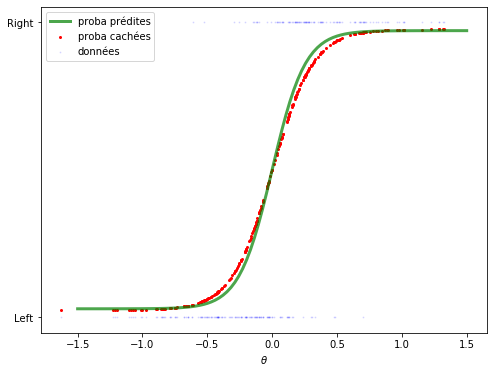

In [6]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


## validation

loss= tensor(0.3992, grad_fn=<BinaryCrossEntropyBackward>)


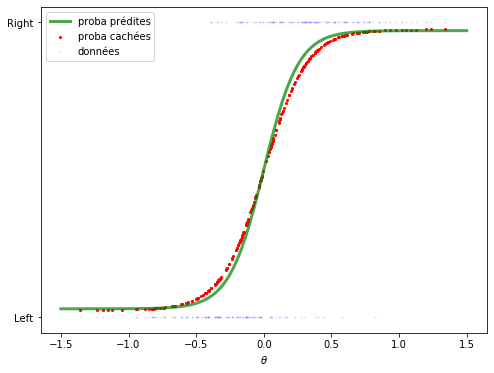

In [7]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();